<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/7_analyze_wave_with_trained_model_8features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install netcdf4

In [0]:
import numpy as np
import pandas as pd
import os
import re
from scipy import stats
import xarray as xr
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
def compute_spectral_features(Dataset):
    """takes in netcdf dataset and computes 8 features"""
    
    spec_power = []
    spec_purs = []
    spec_centroid = []
    spec_spread = []
    spec_skewness = []
    spec_kurtosis = []
    spec_slope = []
    spec_roll_off = []
    
    freq_array = Dataset['freq'].values
    
    #compute power sum using groupby
    spec_power = Dataset.groupby('slices').sum(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values
    
    #compute other features for each slice individually
    for value in Dataset['slices'].values:
        
        spec_pur = stats.gmean(Dataset.sel(slices = value)['__xarray_dataarray_variable__'].values, axis = None) / Dataset.sel(slices = value)['__xarray_dataarray_variable__'].values.mean()
        
        mag_array = Dataset['__xarray_dataarray_variable__'].sel(slices=value).sum(dim = 'times').values
        mag_probs = mag_array/sum(mag_array)
        freq_mag = freq_array*mag_probs
        
        spec_cent = sum(freq_mag)
        spec_spr = np.var(freq_mag)
        spec_skew = stats.skew(freq_mag)
        spec_kurt = stats.kurtosis(freq_mag)
        slope, intercept, r_value, p_value, std_err = stats.linregress(freq_array, freq_mag)
        spec_ro = .95*sum(freq_mag)
        
        spec_purs.append(spec_pur)
        spec_centroid.append(spec_cent)
        spec_spread.append(spec_spr)
        spec_skewness.append(spec_skew)
        spec_kurtosis.append(spec_kurt)
        spec_slope.append(slope)
        spec_roll_off.append(spec_ro)
        
    return spec_power, spec_purs, spec_centroid, spec_spread, spec_skewness, spec_kurtosis, spec_slope, spec_roll_off

In [0]:
#may need to be updated based on file naming scheme
def get_file_info(path, order):
    """takes in a file path for annotation selections table and finds the animal_number and session and saves each accordingly. 
    each file should be named with animal number and exp (e.g. 100_CPA.Table.1.selections)"""
    
    if order == 'animal':
      animal_number, session = re.split('_|-', path.split('/')[-1].split('.')[0])[0:2]
    else:
      session, animal_number = re.split('_|-', path.split('/')[-1].split('.')[0])[0:2] 
    
    print(animal_number, session)
    
    return animal_number, session

In [0]:
netcdf_path = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
path_names = []
files = os.listdir(netcdf_path)
for file in files: 
  path_names.append(netcdf_path + "/" + file)

len(path_names)
path_names

['/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A2_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A4_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A6_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A8_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A10_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A12_D2_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A2_D3_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A4_D3_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A6_D3_xr_Dataset.nc',
 '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain/A8_D3_xr_Dataset.nc',
 '/content/gdrive/

In [0]:
"""takes in path to netcdf file (created using notebook 1), uses compute_spectral_features functions to create a new data set of computed features"""

path = path_names[0]
order = 'animal'
  
animal_number, session = get_file_info(path, order)
print(animal_number, session)

data = xr.open_dataset(path)
print(data['slices'].shape)
    
#compute spectral features
spec_power, spec_purs, spec_centroid, spec_spread, spec_skewness, spec_kurtosis, spec_slope, spec_roll_off = compute_spectral_features(data)
    
#create and fill dataframe for randomly selected noise slices
slice_features_df = pd.DataFrame()
slice_features_df['animal_number'] = [animal_number]*data['slices'].shape[0]
slice_features_df['session'] = [session]*data['slices'].shape[0]
slice_features_df['time_stamp'] = data['slices'].values
slice_features_df['power_sum'] = spec_power
slice_features_df['spec_pur'] = spec_purs
slice_features_df['spec_cent'] = spec_centroid
slice_features_df['spec_spread'] = spec_spread
slice_features_df['spec_skew'] = spec_skewness
slice_features_df['spec_kurt'] = spec_kurtosis
slice_features_df['spec_slope'] = spec_slope
slice_features_df['spec_roll'] = spec_roll_off

A2 D2
A2 D2
(13333,)


In [0]:
slice_features_df = slice_features_df.dropna(axis = 0)
print(slice_features_df.shape)
slice_features_df.head()

(13331, 11)


animal_number session  time_stamp     power_sum  spec_pur     spec_cent   spec_spread  spec_skew  spec_kurt  spec_slope     spec_roll
2            A2      D2        45.0  93832.562500  0.000000  10898.874898  21874.330942   6.600243  46.965189   -0.001388  10353.931153
3            A2      D2        67.5  60386.960938  0.135436  19852.116542   9866.243239   5.131571  32.197299   -0.000863  18859.510714
4            A2      D2        90.0  16293.790039  0.435284  44726.099183   5222.410707  -0.301839   0.318484    0.000982  42489.794224
5            A2      D2       112.5  17724.673828  0.407617  43452.904708   4820.541968  -0.255611   0.654550    0.000770  41280.259472
6            A2      D2       135.0  19126.962891  0.400135  42077.794347   4633.143524  -0.340293   0.242470    0.000599  39973.904629

In [0]:
slice_features = slice_features_df[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
slice_features.head()

power_sum  spec_pur     spec_cent   spec_spread  spec_skew  spec_kurt  spec_slope     spec_roll
2  93832.562500  0.000000  10898.874898  21874.330942   6.600243  46.965189   -0.001388  10353.931153
3  60386.960938  0.135436  19852.116542   9866.243239   5.131571  32.197299   -0.000863  18859.510714
4  16293.790039  0.435284  44726.099183   5222.410707  -0.301839   0.318484    0.000982  42489.794224
5  17724.673828  0.407617  43452.904708   4820.541968  -0.255611   0.654550    0.000770  41280.259472
6  19126.962891  0.400135  42077.794347   4633.143524  -0.340293   0.242470    0.000599  39973.904629

In [0]:
# center and scale the data for train and test sets
scaler = StandardScaler()
slice_features_scaled = scaler.fit_transform(slice_features)

In [0]:
#load saved model
pkl_filename = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/pickled_models/trained_pickle_model_painandCPA_8features_100noise_svmgroup.pkl'
trained_model = pickle.load(open(pkl_filename, 'rb'))
trained_model

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
#use model to classify slices based on features
pred = trained_model.predict(slice_features_scaled)
pred_prob = trained_model.predict_proba(slice_features_scaled)
slice_features_df['pred'] = pred
slice_features_df['pred_proba'] = pred_prob[:,1]
print(pred_prob[pred == 1].shape)
print(pred_prob[pred_prob > .95].shape)
slice_features_df.head()

(6011, 2)
(2674,)


animal_number session  time_stamp     power_sum  spec_pur     spec_cent   spec_spread  spec_skew  spec_kurt  spec_slope     spec_roll  pred  pred_proba
2            A2      D2        45.0  93832.562500  0.000000  10898.874898  21874.330942   6.600243  46.965189   -0.001388  10353.931153     0    0.055078
3            A2      D2        67.5  60386.960938  0.135436  19852.116542   9866.243239   5.131571  32.197299   -0.000863  18859.510714     0    0.051573
4            A2      D2        90.0  16293.790039  0.435284  44726.099183   5222.410707  -0.301839   0.318484    0.000982  42489.794224     0    0.222032
5            A2      D2       112.5  17724.673828  0.407617  43452.904708   4820.541968  -0.255611   0.654550    0.000770  41280.259472     1    0.705952
6            A2      D2       135.0  19126.962891  0.400135  42077.794347   4633.143524  -0.340293   0.242470    0.000599  39973.904629     1    0.820303

In [0]:
pred_prob.mean()

0.5

In [0]:
#use model to classify slices based on features
pred = trained_model.predict(slice_features_scaled)
psd_df['pred'] = pred
print(pred[pred == 1].shape)
psd_df.head()

(13257,)


0.0  0.48828125   0.9765625  1.46484375    1.953125  2.44140625   2.9296875  3.41796875     3.90625  4.39453125   4.8828125   5.37109375     5.859375   6.34765625    6.8359375   7.32421875       7.8125    8.30078125     8.7890625    9.27734375     9.765625  10.25390625   10.7421875  11.23046875     11.71875  12.20703125  12.6953125  13.18359375   13.671875  14.16015625  14.6484375  15.13671875      15.625  16.11328125  16.6015625  17.08984375   17.578125  18.06640625  18.5546875  19.04296875    19.53125  20.01953125  20.5078125  20.99609375   21.484375  21.97265625  22.4609375  22.94921875     23.4375  23.92578125  24.4140625  24.90234375   25.390625  25.87890625  26.3671875  26.85546875    27.34375  27.83203125  28.3203125  28.80859375   29.296875  29.78515625  30.2734375  30.76171875      31.25  31.73828125  32.2265625  32.71484375  33.203125  33.69140625  34.1796875  34.66796875   35.15625  35.64453125  36.1328125  36.62109375  37.109375  37.59765625  38.0859375  \
0.0     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000   
22.5    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000     0.000000   0.000000     0.000000    0.000000   
45.0  211.582657  445.518280  458.627411  408.920868  374.327209  457.324402  576.243042  534.702087  365.076935  421.468842  918.288269  1472.423584  1483.596069  1172.490967  1923.170288  5026.049805  9877.003906  13793.490234  14118.834961  10649.110352  5819.315430  2445.262207  1429.106812  1654.310059  1706.902344  1255.959961  822.584045   747.864502  802.745117   676.222473  433.416260   336.485168  423.263672   478.333374  367.680481   216.803665  212.961899   349.075745  448.346710   393.374573  251.699966   181.347794  271.059662   484.079773  710.378418   842.031372  823.767029   674.401978  471.343506   297.436340  188.430283   128.307922   88.826866    62.319679   55.382195    64.984901   74.160919    69.811203   55.353306    42.919250   38.499786    38.508209   37.623184    35.098438  33.358147    33.796238   35.357773    35.822433  33.907623    31.693354   35.498775    51.607880  77.987442   100.913872  103.809502    82.253098  49.513931    25.277744   18.600794   
67.5   68.427490  109.694138 

In [0]:
psd_df[psd_df['pred'] == 1]

0.0  0.48828125   0.9765625  1.46484375    1.953125  2.44140625    2.9296875   3.41796875      3.90625   4.39453125    4.8828125   5.37109375     5.859375   6.34765625     6.8359375    7.32421875        7.8125    8.30078125     8.7890625    9.27734375      9.765625   10.25390625    10.7421875   11.23046875      11.71875   12.20703125    12.6953125   13.18359375     13.671875   14.16015625    14.6484375   15.13671875        15.625   16.11328125    16.6015625   17.08984375     17.578125   18.06640625    18.5546875   19.04296875      19.53125   20.01953125    20.5078125   20.99609375     21.484375   21.97265625    22.4609375   22.94921875       23.4375  23.92578125   24.4140625  24.90234375    25.390625  25.87890625   26.3671875  26.85546875      27.34375   27.83203125    28.3203125   28.80859375     29.296875   29.78515625   30.2734375  30.76171875        31.25  31.73828125   32.2265625  32.71484375    33.203125  33.69140625    34.1796875   34.66796875     35.15625  \
0.0         0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000     0.000000   
22.5        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000      0.000000      0.000000     0.000000   
45.0      211.582657  445.518280  458.627411  408.920868  374.327209  457.324402   576.243042   534.702087   365.076935   421.468842   918.288269  1472.423584  1483.596069  1172.490967   1923.170288   5026.049805   9877.003906  13793.490234  14118.834961  10649.110352   5819.315430   2445.262207   1429.106812   1654.310059   1706.902344   1255.959961    822.584045    747.864502    802.745117    676.222473    433.416260    336.485168    423.263672    478.333374    367.680481    216.803665    212.961899    349.075745    448.346710    393.374573    251.699966    181.347794    271.059662    484.079773    710.378418    842.031372    823.767029    674.401978    471.343506   297.436340   188.430283   128.307922    88.826866    62.319679    55.382195    64.984901     74.160919     69.811203     55.353306     42.919250     38.499786     38.508209    37.623184    35.098438    33.358147    33.796238    35.357773    35.822433    33.907623    31.693354     35.498775     51.607880    77.987442   
67.5       68.427490  109

In [0]:
#viz predicted calls (need path for corresponding netcdf files)
#netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'

dim = np.int(np.ceil(np.sqrt(slice_features_df.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))

data = xr.open_dataset(path_names[0])

for index, row in slice_features_df.iterrows():
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

KeyboardInterrupt: ignored

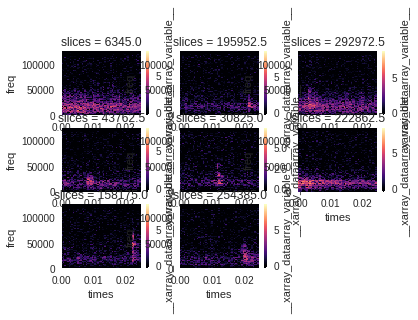

In [0]:
#viz for false positives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_pos_unique = train_upsamples[train_upsamples['pred'] == 'FP'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_pos_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1